In [16]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [17]:
# ---------------------------------
# ① 데이터 로드
# ---------------------------------
vip_df = pd.read_csv("C:\\Users\\seomi\\바탕 화면\\iM Digital academy\\data\\vip_final.csv")

base_features = [
    '총거래금액', 
    '총거래건수', 
    '총예금잔액', 
    '총여신잔액', 
    '대출비중', 
    '상품다양성지수', 
    '총카드사용액', 
    '외환_수출실적금액', 
    '외환_수입실적금액',
    '외부_여신시설자금', 
    '외부_여신운전자금'
]
static_features = ['법인_고객등급', '전담고객여부']

In [18]:
# ---------------------------------
# ② 기준년월 → 분기 변환
# ---------------------------------
vip_df['기준년월'] = pd.to_datetime(vip_df['기준년월'], format='%Y%m')
vip_df['기준분기'] = vip_df['기준년월'].dt.to_period('Q')

In [19]:
# ---------------------------------
# ③ 분기 단위 집계
# ---------------------------------
agg_df = vip_df.groupby(['세그먼트ID', '기준분기']).agg({
    '총거래금액':'mean',
    '총거래건수':'mean',
    '총예금잔액':'mean',
    '총여신잔액':'mean',
    '대출비중':'mean',
    '상품다양성지수':'mean',
    '총카드사용액':'mean',
    '외환_수출실적금액':'mean',
    '외환_수입실적금액':'mean',
    '외부_여신시설자금':'mean',
    '외부_여신운전자금':'mean',
    '법인_고객등급':'first',
    '전담고객여부':'first',
    '이탈여부':'max'  # 분기 내 한 번이라도 이탈하면 1
}).reset_index()

In [20]:
# ---------------------------------
# ④ 타겟(다음 분기 이탈 여부) 생성
# ---------------------------------
agg_df = agg_df.sort_values(['세그먼트ID', '기준분기'])
agg_df['target_next_quarter'] = agg_df.groupby('세그먼트ID')['이탈여부'].shift(-1)
agg_df = agg_df.dropna(subset=['target_next_quarter'])

In [21]:
# ---------------------------------
# ⑤ Feature, Target 분리
# ---------------------------------
X = agg_df[base_features + static_features]
y = agg_df['target_next_quarter']

In [22]:
# ---------------------------------
# ⑥ 모델 정의
# ---------------------------------
models = {
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc'
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42,
        verbose=-1
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=1000,
        solver='lbfgs'
    )
}

In [23]:
# ---------------------------------
# ⑦ 시계열 교차검증
# ---------------------------------
# 36개월(12분기)이므로 3~4개 Fold가 적절
tscv = TimeSeriesSplit(n_splits=4)

results = []
for name, model in models.items():
    auc_scores = []
    f1_scores = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred_proba)
        f1 = precision_recall_fscore_support(y_test, y_pred, average='binary')[2]
        auc_scores.append(auc)
        f1_scores.append(f1)

    results.append({
        'Model': name,
        'Mean AUC': np.mean(auc_scores),
        'Mean F1': np.mean(f1_scores)
    })

In [24]:
# ---------------------------------
# ⑧ 결과 출력
# ---------------------------------
results_df = pd.DataFrame(results).sort_values(by='Mean AUC', ascending=False)
print("\n=== 모델 성능 비교 결과 ===")
print(results_df)


=== 모델 성능 비교 결과 ===
                Model  Mean AUC   Mean F1
0             XGBoost  0.884119  0.710588
2        RandomForest  0.878732  0.701242
1            LightGBM  0.874386  0.691893
3  LogisticRegression  0.752979  0.360530


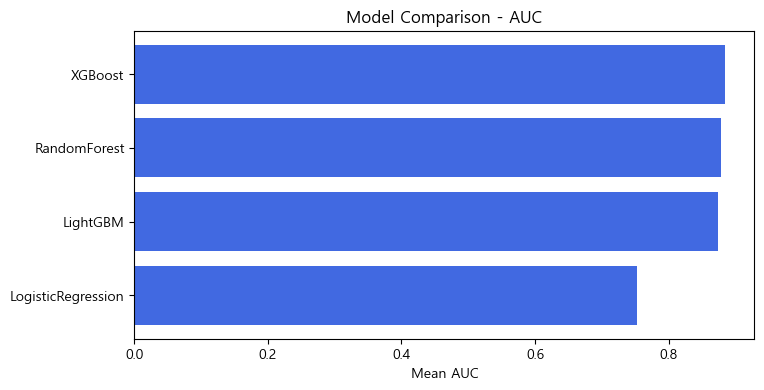

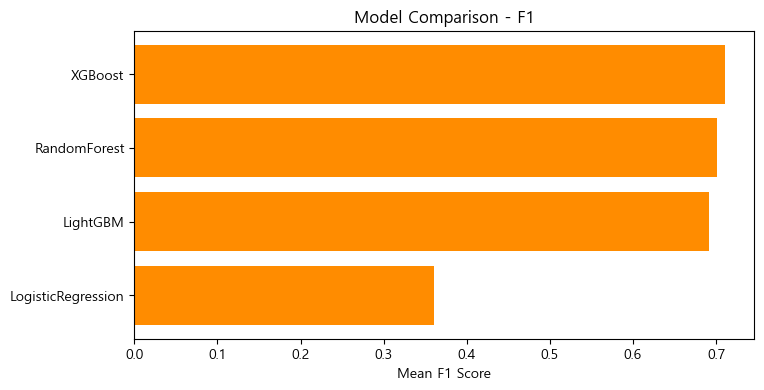

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.barh(results_df['Model'], results_df['Mean AUC'], color='royalblue')
plt.xlabel('Mean AUC')
plt.title('Model Comparison - AUC')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(8,4))
plt.barh(results_df['Model'], results_df['Mean F1'], color='darkorange')
plt.xlabel('Mean F1 Score')
plt.title('Model Comparison - F1')
plt.gca().invert_yaxis()
plt.show()